In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


## Setup

Benford's Law is a common type of numerical distribution observed in numbers generated from many natural distributions. The general idea is, for an arbitrary dataset of numbers, if we look at the leading digit, we should expect the probability of the leading digit to follow the distribution: 

$$P(n) = \log(n + 1) - \log(n)$$

This distributions has applications in fraud detection, for example in financial data, you can apply Benford's law estimate if the "books are being cooked". 

Here are a few great videos describing Benford's Law, and it's applications in fraud detection.

- https://www.youtube.com/watch?v=XXjlR2OK1kM
- https://www.youtube.com/watch?v=vIsDjbhbADY
- https://www.youtube.com/watch?v=7uhAn19V1EY

In this document, we'll apply a chi-squared test to understand if vote counts for Trump and Biden in the 2020 election follow Benford's law. If not, we will try to identify the states that are violating Benford's law. 

We will also run the same analysis on Absentee Ballot Counts where data is available. Unfortunately, the NYT dataset doesn't easily provide Absentee ballot counts for each candidate, so at best we can only look to see if overall absentee ballot counts follow Benford's law.

The dataset used is copied from The New York Times Election Tracker and put into an excel sheet located in `data`: https://www.nytimes.com/interactive/2020/11/03/us/elections/results-president.html

The last collection time for this data at the time of writing is: `Nov 5, 2020 @ 9:39 PM GMT`

### Future Work

A future iteration of this would be to collect vote data from more states in the NYT dataset. 

Another approach would be to mine vote counts from each state's registrar's office so we can get more up-to-date numbers, and get better estimates for Absentee Ballots. At this moment, that's a data munging excercise I am too lazy to pursue, but happy to accept helping hands ^_^

We should also apply a correction method when running multiple chi-squared tests. 

It would also be good to take a Bayesian perspective so we can calculate the Bayes factor and quantify the relative liklihoods of our data with respect to Benford's distribution. 

In [2]:
states = ['Wisconsin', 'Michigan', 'Nevada', 'Arizona', 'North Carolina', 'Pennsylvania', 'Georgia']

datasets = {state: pd.read_excel('data/US Election Data 2020.xlsx', sheet_name=state) for state in states}

datasets['Wisconsin']

,County,Margin,2016 margin,Est. votes reported,Unnamed: 4,Total votes,Absentee
0,Milwaukee,Biden +40,D+36.9,>98%,NaN,458935,—
1,Dane,Biden +53,D+47.3,>98%,NaN,344745,—
2,Waukesha,Trump +21,R+26.7,>98%,NaN,267957,—
3,Brown,Trump +7,R+10.7,>98%,NaN,144011,—
4,Outagamie,Trump +10,R+12.6,>98%,NaN,108223,—
...,...,...,...,...,...,...,...
67,Forest,Trump +31,R+26.6,>98%,NaN,5052,—
68,Pepin,Trump +26,R+23.1,>98%,NaN,4140,—
69,Iron,Trump +22,R+22.9,>98%,NaN,4031,—
70,Florence,Trump +46,R+46.4,>98%,NaN,2939,—


In [3]:
combined_data = pd.concat(datasets, names=['State']).reset_index(level=1, drop=True)

combined_data

,County,Margin,2016 margin,Est. votes reported,Unnamed: 4,Total votes,Absentee
State,,,,,,,
Wisconsin,Milwaukee,Biden +40,D+36.9,>98%,NaN,458935,—
Wisconsin,Dane,Biden +53,D+47.3,>98%,NaN,344745,—
Wisconsin,Waukesha,Trump +21,R+26.7,>98%,NaN,267957,—
Wisconsin,Brown,Trump +7,R+10.7,>98%,NaN,144011,—
Wisconsin,Outagamie,Trump +10,R+12.6,>98%,NaN,108223,—
...,...,...,...,...,...,...,...
Georgia,Dougherty,Biden +40,D+38.4,>98%,NaN,35103,15653
Georgia,Fulton,Biden +46,D+40.9,>98%,NaN,508389,450878
Georgia,Hancock,Biden +44,D+51.9,>98%,NaN,4162,3254


In [4]:
def get_leading_digits(d, sig_figs=1):
    return int(str(d)[:sig_figs])


def benfords_law(n):
    return np.log10(n + 1) - np.log10(n)


def clean_margin(s):
    if s.startswith('Trump'):
        return float(s[7:])
    else:
        return -float(s[7:])
    
    
def estimate_vote_counts_from_margin(df):
    trump_factor = (50 + (df['margin'] / 2)) / 100
    biden_factor = (1 - trump_factor)
    
    df['votes_trump'] = trump_factor * df['votes']
    df['votes_biden'] = biden_factor * df['votes']
    return df


def process_absentees(s):
    if s == '—':
        return None
    else:
        return int(s)

    
def process_nyt_vote_table(df):
    df['votes'] = df['Total votes']
    df['margin'] = df['Margin'].apply(clean_margin)
    df = estimate_vote_counts_from_margin(df)
    df['absentees'] = df['Absentee'].apply(process_absentees)

    return df


def benford_law_histogram(df):
    trump = df['votes_trump'].apply(get_leading_digits)
    biden = df['votes_biden'].apply(get_leading_digits)
    plt.hist(trump[trump != 0], density=True, label='Trump', alpha=0.5, bins=9)
    plt.hist(biden[biden != 0], density=True, label='Biden', alpha=0.5, bins=9)
    ar = np.arange(1, 10)
    plt.plot(ar, benfords_law(ar), label='Benfords Law')
    plt.legend()


def benford_law_votes_chisq_test_pvalues(df):
    trump = df['votes_trump'].apply(get_leading_digits).values
    biden = df['votes_biden'].apply(get_leading_digits).values
    
    sample_size = df.shape[0]
    
    htrump = np.histogram(trump[trump != 0], bins=9, density=False)[0]
    hbiden = np.histogram(biden[biden != 0], bins=9, density=False)[0]
    ar = np.arange(1, 10)
    blaw = benfords_law(ar) * sample_size
    
    return {'Trump': stats.chisquare(htrump, blaw).pvalue, 
            'Biden': stats.chisquare(hbiden, blaw).pvalue}


def benford_law_absentee_chisq_test_pvalues(df):
    absentees = df['absentees'].dropna().apply(get_leading_digits).values
    
    sample_size = absentees.shape
    
    hist = np.histogram(absentees[absentees != 0], bins=9, density=False)[0]
    ar = np.arange(1, 10)
    blaw = benfords_law(ar) * sample_size
    
    return stats.chisquare(hist, blaw).pvalue

In [5]:
processed_data = process_nyt_vote_table(combined_data)

processed_data

,County,Margin,2016 margin,Est. votes reported,Unnamed: 4,Total votes,Absentee,votes,margin,votes_trump,votes_biden,absentees
State,,,,,,,,,,,,
Wisconsin,Milwaukee,Biden +40,D+36.9,>98%,NaN,458935,—,458935,-40.0,137680.500,321254.500,NaN
Wisconsin,Dane,Biden +53,D+47.3,>98%,NaN,344745,—,344745,-53.0,81015.075,263729.925,NaN
Wisconsin,Waukesha,Trump +21,R+26.7,>98%,NaN,267957,—,267957,21.0,162113.985,105843.015,NaN
Wisconsin,Brown,Trump +7,R+10.7,>98%,NaN,144011,—,144011,7.0,77045.885,66965.115,NaN
Wisconsin,Outagamie,Trump +10,R+12.6,>98%,NaN,108223,—,108223,10.0,59522.650,48700.350,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
Georgia,Dougherty,Biden +40,D+38.4,>98%,NaN,35103,15653,35103,-40.0,10530.900,24572.100,15653.0
Georgia,Fulton,Biden +46,D+40.9,>98%,NaN,508389,450878,508389,-46.0,137265.030,371123.970,450878.0
Georgia,Hancock,Biden +44,D+51.9,>98%,NaN,4162,3254,4162,-44.0,1165.360,2996.640,3254.0


### Histograms of the Leading Digit Distribution per Candidate

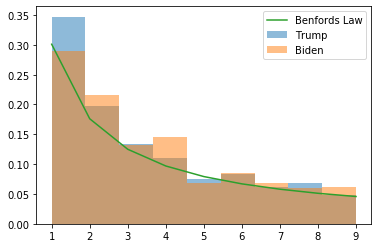

In [6]:
benford_law_histogram(processed_data)

### What are the P-Values associated with each candiate's voting totals?

In [7]:
pvalues = benford_law_votes_chisq_test_pvalues(processed_data)

print(f"Pvalue for Trumps Votes Following Benford's Law: {np.round(pvalues['Trump'] * 100, 2)}%")
print(f"Pvalue for Biden Votes Following Benford's Law: {np.round(pvalues['Biden'] * 100, 2)}%")

Pvalue for Trumps Votes Following Benford's Law: 94.82%
Pvalue for Biden Votes Following Benford's Law: 9.93%


At this stage, both candidates appear to have insignificant diverange from Benford's Law. 

Interestingly, Biden does have a p-value an order of magnitude lower than Trump. Concretely, this means Trump's voter counts currently are more accurately described by Benford's Law than Biden's. 

Of course, we can't go out and shout FRAUD, but it's something to note. 

### What are the P-Values associated with each candidate's voting totals in each state?

In [8]:
for state in states:
    pvalues = benford_law_votes_chisq_test_pvalues(processed_data.loc[state])

    print(f"Pvalue for Trumps Votes Following Benford's Law in {state}: {np.round(pvalues['Trump'] * 100, 2)}%")
    print(f"Pvalue for Biden Votes Following Benford's Law in {state}: {np.round(pvalues['Biden'] * 100, 2)}%")
    print()

Pvalue for Trumps Votes Following Benford's Law in Wisconsin: 98.57%
Pvalue for Biden Votes Following Benford's Law in Wisconsin: 13.29%

Pvalue for Trumps Votes Following Benford's Law in Michigan: 68.77%
Pvalue for Biden Votes Following Benford's Law in Michigan: 8.88%

Pvalue for Trumps Votes Following Benford's Law in Nevada: 47.55%
Pvalue for Biden Votes Following Benford's Law in Nevada: 42.5%

Pvalue for Trumps Votes Following Benford's Law in Arizona: 48.81%
Pvalue for Biden Votes Following Benford's Law in Arizona: 75.23%

Pvalue for Trumps Votes Following Benford's Law in North Carolina: 52.53%
Pvalue for Biden Votes Following Benford's Law in North Carolina: 86.69%

Pvalue for Trumps Votes Following Benford's Law in Pennsylvania: 61.8%
Pvalue for Biden Votes Following Benford's Law in Pennsylvania: 33.16%

Pvalue for Trumps Votes Following Benford's Law in Georgia: 17.98%
Pvalue for Biden Votes Following Benford's Law in Georgia: 11.21%



Here again, we do not see any candidates vote counts devating significantly from Benford's law. 

Interestingly, in the hotly contested states of Wisconsin, Michigan, Pennsylvania and Georgia, Biden consistently has a lower P-value than Trump. 

Overall, out of the 7 states currently tracked, Biden has a lower P-value in 5 out of 7 states. Assuming both candidate's vote counts follow Benford's Law, we would expect to see this: **16.4%** of the time. 

### What is the P-Value associated with Absentee Ballots following Benford's law?

In [9]:
absentee_pval = benford_law_absentee_chisq_test_pvalues(processed_data)

print(f"The P-value that our data follows Benford's Law: {np.round(absentee_pval * 100, 2)}%")

The P-value that our data follows Benford's Law: 61.33%


On aggregate, our Absentee ballot counts appear to be well explained by Benford's law. Unfortunately, do the the current data, we do not have easy access to each candidates absentee count distribution. 